# BirdSet Manifest Analysis

This notebook reads a newline-delimited JSON manifest (e.g. `snippets_manifest.jsonl`) produced by your cutting script and computes quick summaries.

**Assumptions about each manifest row:**
```json
{
  "config": "XCL",
  "species": "canary",
  "src": "/path/to/source_audio.ogg",
  "start": 12.345,
  "end": 14.210,
  "dst": "/path/to/snippet.flac"   # or .ogg
}
```


In [1]:
from pathlib import Path
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- Edit this to your manifest path ----
MANIFEST_PATH = Path("/media/george-vengrovski/disk1/snippets_manifest.jsonl")
# Optional: where to write summary CSVs
OUTPUT_DIR = MANIFEST_PATH.parent / "manifest_summaries"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

MANIFEST_PATH


PosixPath('/media/george-vengrovski/disk1/snippets_manifest.jsonl')

In [2]:
def load_jsonl(path: Path, use_pandas=True):
    if use_pandas:
        # Fast path using pandas
        return pd.read_json(path, lines=True)
    # Fallback manual loader
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line: 
                continue
            rows.append(json.loads(line))
    return pd.DataFrame(rows)

df = load_jsonl(MANIFEST_PATH, use_pandas=True)
len(df), df.head()


(4043269,
   config  species                                                src  start  \
 0    XCL  ostric2  /media/george-vengrovski/disk1/XCL_RAW/hf/data...  5.696   
 1    XCL  ostric2  /media/george-vengrovski/disk1/XCL_RAW/hf/data...  1.376   
 2    XCL  ostric2  /media/george-vengrovski/disk1/XCL_RAW/hf/data...  2.656   
 3    XCL  ostric2  /media/george-vengrovski/disk1/XCL_RAW/hf/data...  2.096   
 4    XCL  ostric2  /media/george-vengrovski/disk1/XCL_RAW/hf/data...  6.960   
 
      end                                                dst  
 0  6.528  /media/george-vengrovski/disk1/XCL_oggs/XCL_os...  
 1  2.192  /media/george-vengrovski/disk1/XCL_oggs/XCL_os...  
 2  4.320  /media/george-vengrovski/disk1/XCL_oggs/XCL_os...  
 3  3.536  /media/george-vengrovski/disk1/XCL_oggs/XCL_os...  
 4  8.144  /media/george-vengrovski/disk1/XCL_oggs/XCL_os...  )

In [3]:
expected_cols = {"config","species","src","start","end","dst"}
print("Columns:", list(df.columns))
print("Missing expected:", expected_cols - set(df.columns))
print("Rows:", len(df))

# durations
df['duration'] = df['end'] - df['start']
# file type from dst extension
df['ext'] = df['dst'].apply(lambda p: Path(p).suffix.lower())
df[['species','config','duration','ext']].head()


Columns: ['config', 'species', 'src', 'start', 'end', 'dst']
Missing expected: set()
Rows: 4043269


,species,config,duration,ext
0,ostric2,XCL,0.832,.ogg
1,ostric2,XCL,0.816,.ogg
2,ostric2,XCL,1.664,.ogg
3,ostric2,XCL,1.440,.ogg
4,ostric2,XCL,1.184,.ogg


In [4]:
summary = {
    "rows": len(df),
    "unique_species": df['species'].nunique(),
    "configs": df['config'].value_counts().to_dict(),
    "by_ext": df['ext'].value_counts().to_dict(),
    "duration_sec_total": float(df['duration'].sum()),
    "duration_sec_mean": float(df['duration'].mean()),
    "duration_sec_p50": float(df['duration'].median()),
    "duration_sec_p95": float(df['duration'].quantile(0.95)),
}
summary


{'rows': 4043269,
 'unique_species': 7249,
 'configs': {'XCL': 4043269},
 'by_ext': {'.flac': 3836734, '.ogg': 206535},
 'duration_sec_total': 7756991.359999999,
 'duration_sec_mean': 1.9184949999616645,
 'duration_sec_p50': 1.151999999999994,
 'duration_sec_p95': 5.52}

In [5]:
topN = 30
species_counts = df.groupby('species').size().sort_values(ascending=False)
species_dur = df.groupby('species')['duration'].sum().sort_values(ascending=False)

species_counts.head(topN).to_csv(OUTPUT_DIR / "species_top_counts.csv", header=['count'])
species_dur.head(topN).to_csv(OUTPUT_DIR / "species_top_duration_sec.csv", header=['duration_sec'])

species_counts.head(10), species_dur.head(10)


(species
 eurrob1    103945
 gretit1     82733
 comnig1     66578
 blrwar1     49310
 marwar3     43961
 winwre4     38924
 comcuc      34915
 thrnig1     29762
 tawowl1     28020
 ictwar1     27302
 dtype: int64,
 species
 eurrob1    168930.352
 marwar3    155267.456
 comnig1    153313.600
 gretit1    151099.280
 blrwar1    130711.168
 winwre4     95976.208
 ictwar1     77451.440
 thrnig1     73801.008
 eurwar1     72196.304
 sedwar1     61936.704
 Name: duration, dtype: float64)

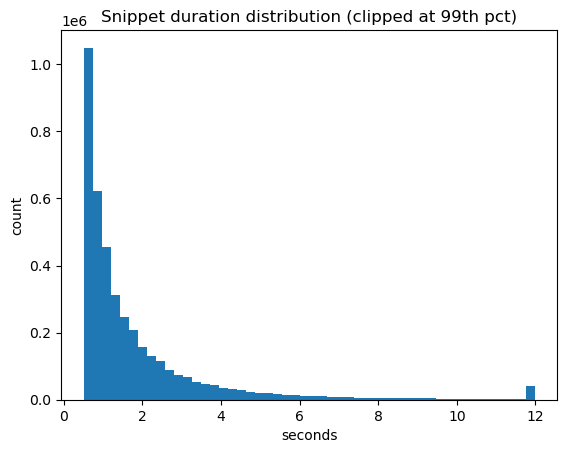

In [6]:
# Duration histogram
plt.figure()
_ = plt.hist(df['duration'].clip(lower=0, upper=df['duration'].quantile(0.99)), bins=50)
plt.title("Snippet duration distribution (clipped at 99th pct)")
plt.xlabel("seconds")
plt.ylabel("count")
plt.show()


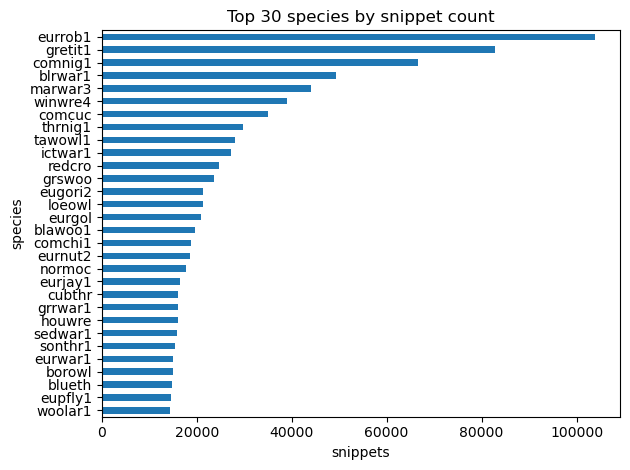

In [7]:
# Top 30 species by snippet count
topN = 30
plt.figure()
species_counts.head(topN).iloc[::-1].plot(kind='barh')
plt.title(f"Top {topN} species by snippet count")
plt.xlabel("snippets")
plt.ylabel("species")
plt.tight_layout()
plt.show()


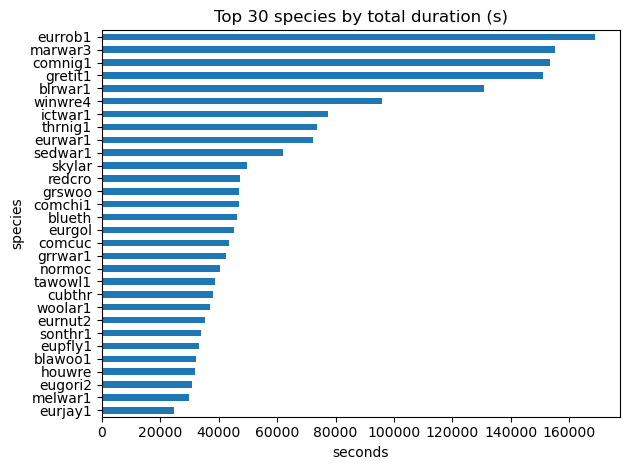

In [8]:
# Top 30 species by total duration
topN = 30
plt.figure()
species_dur.head(topN).iloc[::-1].plot(kind='barh')
plt.title(f"Top {topN} species by total duration (s)")
plt.xlabel("seconds")
plt.ylabel("species")
plt.tight_layout()
plt.show()


In [9]:
def safe_size(p):
    try:
        return os.path.getsize(p)
    except Exception:
        return np.nan

sample = df.sample(min(5000, len(df)), random_state=0)  # cap to limit IO cost
sample['bytes'] = sample['dst'].apply(safe_size)
print("Measured files:", sample['bytes'].notna().sum())
print("Mean size (KB):", sample['bytes'].mean() / 1024)
print("Share missing on disk:", sample['bytes'].isna().mean())
sample[['dst','bytes']].head()


Measured files: 5000
Mean size (KB): 186.099493359375
Share missing on disk: 0.0


,dst,bytes
804109,/media/george-vengrovski/disk1/XCL_oggs/XCL_gr...,214686
2726593,/media/george-vengrovski/disk1/XCL_oggs/XCL_eu...,460075
1436072,/media/george-vengrovski/disk1/XCL_oggs/XCL_su...,127405
876267,/media/george-vengrovski/disk1/XCL_oggs/XCL_sw...,380342
3096577,/media/george-vengrovski/disk1/XCL_oggs/XCL_gr...,385282


In [10]:
per_species = df.groupby('species').agg(
    count=('species','size'),
    total_duration_s=('duration','sum'),
    median_duration_s=('duration','median')
).sort_values('count', ascending=False)
per_species.to_csv(OUTPUT_DIR / "per_species_summary.csv")
per_species.head(20)


,count,total_duration_s,median_duration_s
species,,,
eurrob1,103945,168930.352,1.104
gretit1,82733,151099.280,1.264
comnig1,66578,153313.600,1.856
blrwar1,49310,130711.168,1.264
marwar3,43961,155267.456,1.664
winwre4,38924,95976.208,1.360
comcuc,34915,43549.056,0.736
thrnig1,29762,73801.008,1.552
tawowl1,28020,38685.232,1.040


In [12]:
# Change this to a species string in your manifest to preview
SPECIES = "comcan"
df[df['species'] == SPECIES].head(10)


,config,species,src,start,end,dst,duration,ext
2536124,XCL,comcan,/media/george-vengrovski/disk1/XCL_RAW/hf/data...,0.016,2.112,/media/george-vengrovski/disk1/XCL_oggs/XCL_co...,2.096,.flac
2536125,XCL,comcan,/media/george-vengrovski/disk1/XCL_RAW/hf/data...,2.576,4.128,/media/george-vengrovski/disk1/XCL_oggs/XCL_co...,1.552,.flac
2536126,XCL,comcan,/media/george-vengrovski/disk1/XCL_RAW/hf/data...,10.640,12.144,/media/george-vengrovski/disk1/XCL_oggs/XCL_co...,1.504,.flac
2536128,XCL,comcan,/media/george-vengrovski/disk1/XCL_RAW/hf/data...,9.296,10.000,/media/george-vengrovski/disk1/XCL_oggs/XCL_co...,0.704,.flac
2536129,XCL,comcan,/media/george-vengrovski/disk1/XCL_RAW/hf/data...,4.768,9.296,/media/george-vengrovski/disk1/XCL_oggs/XCL_co...,4.528,.flac
2536130,XCL,comcan,/media/george-vengrovski/disk1/XCL_RAW/hf/data...,13.840,15.472,/media/george-vengrovski/disk1/XCL_oggs/XCL_co...,1.632,.flac
2536133,XCL,comcan,/media/george-vengrovski/disk1/XCL_RAW/hf/data...,15.648,18.944,/media/george-vengrovski/disk1/XCL_oggs/XCL_co...,3.296,.flac
2536135,XCL,comcan,/media/george-vengrovski/disk1/XCL_RAW/hf/data...,20.528,21.520,/media/george-vengrovski/disk1/XCL_oggs/XCL_co...,0.992,.flac
2536136,XCL,comcan,/media/george-vengrovski/disk1/XCL_RAW/hf/data...,27.936,28.448,/media/george-vengrovski/disk1/XCL_oggs/XCL_co...,0.512,.flac
2536137,XCL,comcan,/media/george-vengrovski/disk1/XCL_RAW/hf/data...,23.120,27.456,/media/george-vengrovski/disk1/XCL_oggs/XCL_co...,4.336,.flac


## Move to Validation Files 5 precent of species by volume + atlantic canaries


In [13]:
# %% BirdSet: select Canary + 5% other files (by whole species) → val_files, rest → train_files

from pathlib import Path
import json, os, shutil, random
import pandas as pd
import numpy as np

# ---- CONFIG ----
MANIFEST_PATH = Path("/media/george-vengrovski/disk1/snippets_manifest.jsonl")  # adjust if needed
SNIPPET_ROOT  = Path("/media/george-vengrovski/disk1/XCL_oggs")                # where the .flac/.ogg live
OUT_BASE      = SNIPPET_ROOT.parent
VAL_DIR       = OUT_BASE / "val_files"
TRAIN_DIR     = OUT_BASE / "train_files"

# Candidate eBird codes to try for Atlantic/Island/Common Canary
CANARY_CANDIDATES = ["comcan"]  # we'll auto-pick the first one present
CANARY_CODE = "comcan"   # set explicitly to a code to override auto-pick, e.g., "comcan"

TARGET_VAL_FRAC = 0.05   # ≈5% of non-canary files, but entire species at a time
SEED            = 13
MOVE_FILES      = True   # False → copy instead
DRY_RUN         = False  # True → plan only, no filesystem writes

# ---- LOAD ----
df = pd.read_json(MANIFEST_PATH, lines=True)
if "species" not in df.columns or "dst" not in df.columns:
    raise ValueError("Manifest must have columns: species, dst, start, end, config")

# Normalize paths
df["dst"] = df["dst"].apply(lambda p: str(Path(p)))

# ---- FIND CANARY CODE FROM MANIFEST ----
species_counts = df.groupby("species").size().sort_values(ascending=False)
present_candidates = [c for c in CANARY_CANDIDATES if c in species_counts.index]
if CANARY_CODE is None:
    if present_candidates:
        CANARY_CODE = present_candidates[0]
    else:
        # Show likely candidates to set manually
        print("Could not auto-verify Canary code from candidates:", CANARY_CANDIDATES)
        print("Top codes containing 'can':")
        display(species_counts[species_counts.index.str.contains("can", case=False)].head(20))
        raise SystemExit("Set CANARY_CODE manually above and re-run.")
print("Using CANARY_CODE:", CANARY_CODE)

# ---- BUILD VAL SPECIES SET: Canary + whole species until ~5% of other files ----
rng = random.Random(SEED)

non_canary = species_counts.drop(index=[CANARY_CODE]) if CANARY_CODE in species_counts.index else species_counts
total_non_canary_files = int(non_canary.sum())
target_files = int(round(TARGET_VAL_FRAC * total_non_canary_files))

species_list = list(non_canary.index)
rng.shuffle(species_list)

val_species = {CANARY_CODE}
running = 0
for sp in species_list:
    if running >= target_files:
        break
    val_species.add(sp)
    running += int(non_canary.loc[sp])

train_species = set(species_counts.index) - val_species

print(f"Val species: {len(val_species)}  Train species: {len(train_species)}")
print(f"Target non-canary files ≈ {target_files}, planned non-canary files in val ≈ {running}")
print("Example val species:", list(sorted(list(val_species)))[:10])

# ---- PLAN FILE MOVES ----
val_mask = df["species"].isin(val_species)
df_val = df[val_mask].copy()
df_trn = df[~val_mask].copy()

print(f"Val files: {len(df_val):,}  Train files: {len(df_trn):,}")

# Ensure output dirs
if not DRY_RUN:
    VAL_DIR.mkdir(parents=True, exist_ok=True)
    TRAIN_DIR.mkdir(parents=True, exist_ok=True)

def safe_move_or_copy(src: str, dst_dir: Path, idx: int):
    src_p = Path(src)
    if not src_p.exists():
        return "missing"
    base = src_p.name
    dst_p = dst_dir / base
    # Handle potential name collisions
    if dst_p.exists():
        stem, ext = dst_p.stem, dst_p.suffix
        dst_p = dst_dir / f"{stem}__dup{idx}{ext}"
    if DRY_RUN:
        return "planned"
    try:
        if MOVE_FILES:
            shutil.move(str(src_p), str(dst_p))
        else:
            shutil.copy2(str(src_p), str(dst_p))
        return "ok"
    except Exception:
        return "error"

# ---- EXECUTE ----
stats = {"val_ok":0,"val_missing":0,"val_error":0,"trn_ok":0,"trn_missing":0,"trn_error":0}

for i, row in enumerate(df_val.itertuples(index=False), 1):
    res = safe_move_or_copy(row.dst, VAL_DIR, i)
    stats[f"val_{res}"] = stats.get(f"val_{res}",0) + 1
for i, row in enumerate(df_trn.itertuples(index=False), 1):
    res = safe_move_or_copy(row.dst, TRAIN_DIR, i)
    stats[f"trn_{res}"] = stats.get(f"trn_{res}",0) + 1

# ---- SAVE SPLIT METADATA ----
split_info = {
    "canary_code": CANARY_CODE,
    "val_species": sorted(list(val_species)),
    "train_species": sorted(list(train_species)),
    "val_counts": int(df_val.shape[0]),
    "train_counts": int(df_trn.shape[0]),
    "target_val_frac_non_canary": TARGET_VAL_FRAC,
    "actual_val_frac_non_canary": (running / max(1,total_non_canary_files))
}
if not DRY_RUN:
    with open(OUT_BASE / "split_summary.json", "w", encoding="utf-8") as f:
        json.dump(split_info, f, indent=2)
    (OUT_BASE / "val_species.txt").write_text("\n".join(split_info["val_species"]))
    (OUT_BASE / "train_species.txt").write_text("\n".join(split_info["train_species"]))

print("Done.")
print("Stats:", stats)
print("Summary path:", OUT_BASE / "split_summary.json")


Using CANARY_CODE: comcan
Val species: 449  Train species: 6800
Target non-canary files ≈ 202110, planned non-canary files in val ≈ 202234
Example val species: ['acowoo', 'aldfly', 'alpswi1', 'ancdov1', 'anctap1', 'andduc1', 'andgoo1', 'andgul1', 'arcwar3', 'arfcat1']
Val files: 203,312  Train files: 3,839,957
Done.
Stats: {'val_ok': 203312, 'val_missing': 0, 'val_error': 0, 'trn_ok': 3839957, 'trn_missing': 0, 'trn_error': 0}
Summary path: /media/george-vengrovski/disk1/split_summary.json
